In [1]:
import sys,os
import pandas as pd
import numpy as np
import warnings

import tensorflow as tf
from sklearn.utils import shuffle
from joblib import load, dump
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.metrics import structural_similarity as ssim

from aggmap import AggMap
from aggmap.utils.matrixopt import smartpadding
import aggmap

sns.set(style = 'white', font_scale=1.5)

warnings.filterwarnings("ignore")

import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#34ebe8",'gray', 'k'])



## usefull link: https://towardsdatascience.com/how-to-program-umap-from-scratch-e6eff67f55fe

/home/shenwanxiang/anaconda3/envs/molmap/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shenwanxiang/anaconda3/envs/molmap/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shenwanxiang/anaconda3/envs/molmap/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/s

## $\sum_{e\in E} w_h(e) \log\left(\frac{w_h(e)}{w_l(e)}\right) + (1 - w_h(e)) \log\left(\frac{1 - w_h(e)}{1 - w_l(e)}\right)$

### This might look complicated, but if we go back to thinking in terms of a graph we can view minimizing the cross entropy as a kind of force directed graph layout algorithm.

### The first term, $w_h(e) \log\left(\frac{w_h(e)}{w_l(e)}\right)$, provides an attractive force between the points e spans whenever there is a large weight associated to the high dimensional case. This is because this term will be minimized when $w_l(e)$ is as large as possible, which will occur when the distance between the points is as small as possible.

### In contrast the second term, $(1 - w_h(e)) \log\left(\frac{1 - w_h(e)}{1 - w_l(e)}\right)$, provides a repulsive force between the ends of e whenever $w_h(e)$ is small. This is because the term will be minimized by making w_l(e) as small as possible.

### On balance this process of pull and push, mediated by the weights on edges of the topological representation of the high dimensional data, will let the low dimensional representation settle into a state that relatively accurately represents the overall topology of the source data.

In [2]:
from scipy.spatial.distance import cdist, squareform
from scipy.stats import entropy, truncnorm

def get_graph_v(embd):
    '''
    Get the graph in low dimension
    '''
    distances = cdist(embd.embedding_, embd.embedding_)
    a = embd._a
    b = embd._b
    graph_v = 1.0 / (1.0 + a * distances ** (2 * b))        
    return graph_v

def get_graph_u(embd):
    '''
    Get the graph in high dimension
    '''
    return embd.graph_.toarray()

def cross_entropy_via_scipy(gu, gv):
        ''' SEE: https://en.wikipedia.org/wiki/Cross_entropy'''
        return  entropy(gu) + entropy(gu, gv)
    
def get_loss_pcc_from_embd(embd):
    gv = get_graph_v(embd)
    np.fill_diagonal(gv,0)
    gv = squareform(gv)
    gu = get_graph_u(embd)
    gu = squareform(gu)
    l1 = pd.Series(gu).to_frame(name = 'y_true')
    l2 = pd.Series(gv).to_frame(name = 'y_pred')
    pcc = l1.join(l2).corr().iloc[0].iloc[1]
    loss = cross_entropy_via_scipy(gu, gv)
    return loss, pcc

In [3]:
img_save_dir = './frames/MNIST'
if not os.path.exists(img_save_dir):
    os.makedirs(img_save_dir)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #
label_idx = pd.Series(y_train).to_frame(name='label').groupby('label').apply(lambda x:x.index.tolist())
label_idx

label
0    [1, 21, 34, 37, 51, 56, 63, 68, 69, 75, 81, 88...
1    [3, 6, 8, 14, 23, 24, 40, 59, 67, 70, 72, 77, ...
2    [5, 16, 25, 28, 76, 82, 109, 117, 120, 122, 14...
3    [7, 10, 12, 27, 30, 44, 49, 50, 74, 86, 98, 10...
4    [2, 9, 20, 26, 53, 58, 60, 61, 64, 89, 92, 115...
5    [0, 11, 35, 47, 65, 100, 132, 138, 145, 173, 1...
6    [13, 18, 32, 36, 39, 62, 66, 73, 83, 90, 93, 1...
7    [15, 29, 38, 42, 52, 71, 79, 84, 91, 96, 101, ...
8    [17, 31, 41, 46, 55, 85, 94, 97, 125, 137, 144...
9    [4, 19, 22, 33, 43, 45, 48, 54, 57, 80, 87, 11...
dtype: object

In [5]:
_, w, h = x_train.shape
orignal_cols = ['p-%s' % str((i+1)).zfill(len(str(w*h))) for i in range(w*h)]
x_train_df = pd.DataFrame(x_train.reshape(x_train.shape[0], w*h), columns = orignal_cols)
x_test_df = pd.DataFrame(x_test.reshape(x_test.shape[0], w*h), columns = orignal_cols)


### random permutation

In [6]:
shuffled_cols = shuffle(orignal_cols, random_state=111)
x_train_df_shuffled = x_train_df[shuffled_cols]
x_test_df_shuffled = x_test_df[shuffled_cols]

In [7]:
mp = AggMap(x_train_df_shuffled, metric='correlation')

2021-10-29 21:35:38,506 - INFO - [bidd-aggmap] - Calculating distance ...
2021-10-29 21:35:38,537 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:01<00:00, 397.09it/s]


In [8]:
idx_to_plot = label_idx.iloc[[1,3,5,7,9]].apply(lambda x:x[0])
idx_to_plot.index = idx_to_plot.index.astype(str)
idx_to_plot.to_dict()

{'1': 3, '3': 7, '5': 0, '7': 15, '9': 4}

In [ ]:
total_epochs = 500
begin_epochs = 1 # Need to comment out the error throwing of epochs less than 10 in UMAP
step = 1

learning_rate = 5e-1

epochs_list = list(range(begin_epochs, total_epochs+1, step))
dfp = pd.DataFrame(index = epochs_list)

loss_history = []
pcc_history = []
ssim_histroy = []

X_shuffled = x_train_df_shuffled.values
X_orignal = x_train

ssim_plots_org = []
for i,j in idx_to_plot.items():
    rd_init = X_shuffled[j].reshape(w, h)
    old = X_orignal[j].reshape(w, h)    
    ssim_plots_org.append(ssim(old, rd_init))
# ssim_histroy.append({'Epochs':begin_epochs, 'ssim_plots':dict(zip(idx_to_plot.keys(), ssim_plots_org))})
# loss_history.append({'Epochs':begin_epochs,'Loss':10.55})
# pcc_history.append({'Epochs':begin_epochs,'PCC':0.51})

for n_epochs in epochs_list:
    ## fit on the randomized data(permuted images)
    mp = mp.fit(n_epochs = n_epochs, learning_rate = learning_rate, cluster_channels=1, var_thr=0, verbose=0)    
    X_restore = mp.batch_transform(x_train_df_shuffled.values[idx_to_plot.tolist()], scale=False)
    
    X_shuffled_plots = []
    X_orignal_plots = []
    X_restore_plots = []
    ssim_plots = []
    k = 0
    
    for i,j in idx_to_plot.items():
        #permuted
        rd_init = X_shuffled[j].reshape(w, h)
        X_shuffled_plots.append(rd_init)

        #orignal
        old = X_orignal[j].reshape(w, h)
        X_orignal_plots.append(old)

        #reconstruction
        new = X_restore[k].reshape(*mp.fmap_shape)
        new = np.pad(new, ((0,1),(1,0)))
        X_restore_plots.append(new)

        ssim_score = ssim(old, new) 
        ssim_plots.append(ssim_score)
        k += 1
        
    loss, pcc = get_loss_pcc_from_embd(mp.embedded)
    loss_history.append({'Epochs':n_epochs,'Loss':loss})
    pcc_history.append({'Epochs':n_epochs,'PCC':pcc})
    ssim_plots = dict(zip(idx_to_plot.keys(), ssim_plots))
    ssim_histroy.append({'Epochs':n_epochs, 'ssim_plots':ssim_plots})
    

    fig = plt.figure( figsize = (25,14))

    grid = plt.GridSpec(4, 7, wspace=0.25,   hspace=0.25,)


    LS_ax = fig.add_subplot(grid[0, :2])
    PCC_ax = fig.add_subplot(grid[1, :2])
    SSIM_ax = fig.add_subplot(grid[2, :2])
    Epochs_ax = fig.add_subplot(grid[3, :2])


    gt1 = fig.add_subplot(grid[0, 2:3])
    gt3 = fig.add_subplot(grid[0, 3:4])
    gt5 = fig.add_subplot(grid[0, 4:5])
    gt7 = fig.add_subplot(grid[0, 5:6])
    gt9 = fig.add_subplot(grid[0, 6:7])


    rd1 = fig.add_subplot(grid[1, 2:3])
    rd3 = fig.add_subplot(grid[1, 3:4])
    rd5 = fig.add_subplot(grid[1, 4:5])
    rd7 = fig.add_subplot(grid[1, 5:6])
    rd9 = fig.add_subplot(grid[1, 6:7])

    st1 = fig.add_subplot(grid[2, 2:3])
    st3 = fig.add_subplot(grid[2, 3:4])
    st5 = fig.add_subplot(grid[2, 4:5])
    st7 = fig.add_subplot(grid[2, 5:6])
    st9 = fig.add_subplot(grid[2, 6:7])


    rst1 = fig.add_subplot(grid[3, 2:3])
    rst3 = fig.add_subplot(grid[3, 3:4])
    rst5 = fig.add_subplot(grid[3, 4:5])
    rst7 = fig.add_subplot(grid[3, 5:6])
    rst9 = fig.add_subplot(grid[3, 6:7])

    pd.DataFrame(loss_history).set_index('Epochs').plot(ax = LS_ax, lw = 2)
    LS_ax.set_xlabel('')
    LS_ax.set_ylabel('CE Loss')
    LS_ax.set_xlim(begin_epochs, total_epochs)
    LS_ax.set_ylim(10.3, 10.7)
    LS_ax.set_title('Epochs: %s / %s' % (n_epochs, total_epochs), fontsize=25)
    
    pd.DataFrame(pcc_history).set_index('Epochs').plot(ax = PCC_ax, lw = 2)
    PCC_ax.set_xlabel('')
    PCC_ax.set_ylabel('PCC')
    PCC_ax.set_xlim(begin_epochs, total_epochs)
    PCC_ax.set_ylim(0.40, 0.579)
    
    dfss = pd.DataFrame(ssim_histroy).set_index('Epochs').ssim_plots.apply(pd.Series)
    dfss.plot(ax = SSIM_ax, lw = 1.5)
    SSIM_ax.set_xlabel('')
    SSIM_ax.set_ylabel('SSIM to Ground Truth')
    SSIM_ax.set_xlim(begin_epochs, total_epochs)
    SSIM_ax.set_ylim(-0.12523882291777522, 0.9276889339009697)
    
    loss_ = r"1) $CE(μ,v)=\sum_{a\in A} μ(a)\log\left(\frac{μ(a)}{v(a)}\right) + (1 - μ(a)) \log\left(\frac{1 - μ(a)}{1 - v(a)}\right)$"
    pcc_ = r"2) $PCC{(μ,v)} = {Cov(μ,v)} / ({δ_{μ}*δ_{v}})$"
    ssim_ = "3) SSIM: Structural Similarity Index"

    #Epochs_ax.text(0.1, 0.45, 'Epochs: %s / %s' % (n_epochs, total_epochs), fontdict = {'fontsize':30})
    Epochs_ax.text(-0.15, 0.75, loss_, fontsize=18)
    Epochs_ax.text(-0.15, 0.45, pcc_, fontsize=18)
    Epochs_ax.text(-0.15, 0.15, ssim_, fontsize=18)

    
    Epochs_ax.set_axis_off()

    for ax, x, label in zip([gt1, gt3, gt5, gt7, gt9], X_orignal_plots, idx_to_plot.keys()):
        ax.imshow(x, cmap = 'gray')
        ax.set_title(label, fontdict = {'fontsize':30})
        ax.set_xticks([])
        ax.set_yticks([])
        if label == '9':
            ax.set_ylabel('Ground Truth', fontdict = {'fontsize':25})
            ax.yaxis.set_label_position("right")

    for ax, x, label in zip([rd1, rd3, rd5, rd7, rd9], X_shuffled_plots, idx_to_plot.keys()):
        ax.imshow(x, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        if label == '9':
            ax.set_ylabel('Randomized', fontdict = {'fontsize':25})
            ax.yaxis.set_label_position("right")


    for ax, label, idx in zip([st1, st3, st5, st7, st9], idx_to_plot.keys(), idx_to_plot.values):
        x = mp.df_embedding.x
        y = -mp.df_embedding.y
        c = mp.df_embedding.join(x_train_df_shuffled.iloc[idx].to_frame(name = 'pix')).pix
        ax.scatter(x, y, c = c, cmap = cmap, s=5)
        ax.set_xticks([])
        ax.set_yticks([])
        if label == '9':
            ax.set_ylabel('Embedded', fontdict = {'fontsize':25})
            ax.yaxis.set_label_position("right")


    for ax, x, label in zip([rst1, rst3, rst5, rst7, rst9], X_restore_plots, idx_to_plot.keys()):
        ax.imshow(x, cmap = cmap)
        ax.set_xticks([])
        ax.set_yticks([])
        if label == '9':
            ax.set_ylabel('Restructured', fontdict = {'fontsize':25})
            ax.yaxis.set_label_position("right")

    fig.tight_layout()
    
    fig.savefig(os.path.join(img_save_dir,'./%s.jpg' % str(n_epochs).zfill(5)), bbox_inches='tight', dpi=300) 
    

In [ ]:
pd.DataFrame(loss_history).set_index('Epochs').join(pd.DataFrame(pcc_history).set_index('Epochs')).to_csv('./history_mnist.csv')

In [13]:
embd = mp.embedded

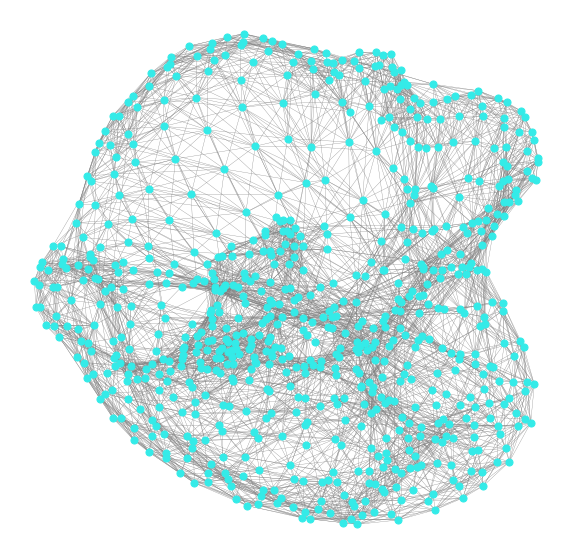

In [109]:
import networkx as nx

fig, ax = plt.subplots(figsize = (10, 10))
A = embd.graph_.toarray()

G = nx.from_numpy_matrix(np.matrix(A))
layout = nx.spring_layout(G, iterations = 500)
nx.draw(G, layout, ax = ax, node_size = 50, edge_color = 'gray', width = 0.3, node_color= '#34ebe8')
#nx.draw_networkx_edge_labels(G, pos=layout)
fig.savefig('./svg/graph_orignal.svg', bbox_inches='tight', dpi=300) 

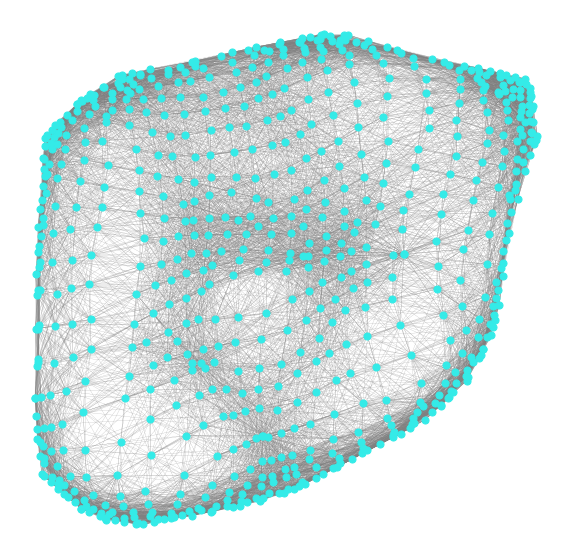

In [82]:
fig, ax = plt.subplots(figsize = (10, 10))
gv = get_graph_v(embd)
#np.fill_diagonal(gv,0)

A = gv*(gv > 0.28)

G = nx.from_numpy_matrix(np.matrix(A))
layout = nx.spring_layout(G, iterations = 500)
nx.draw(G, layout, ax = ax, node_size = 50, edge_color = 'gray', width = 0.15, node_color= '#34ebe8')
#nx.draw_networkx_edge_labels(G, pos=layout)
fig.savefig('./svg/graph_optimized.svg', bbox_inches='tight', dpi=300) 

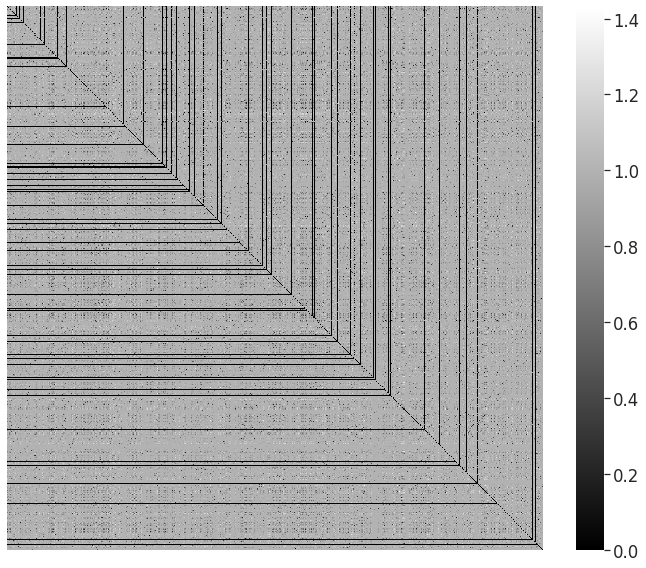

In [113]:
fig, ax = plt.subplots(figsize = (12, 10))
sns.heatmap(squareform(mp.info_distance,), ax = ax, cmap = 'gray')
plt.axis('off')
fig.savefig('./svg/dist_orignal.svg', bbox_inches='tight', dpi=300) 

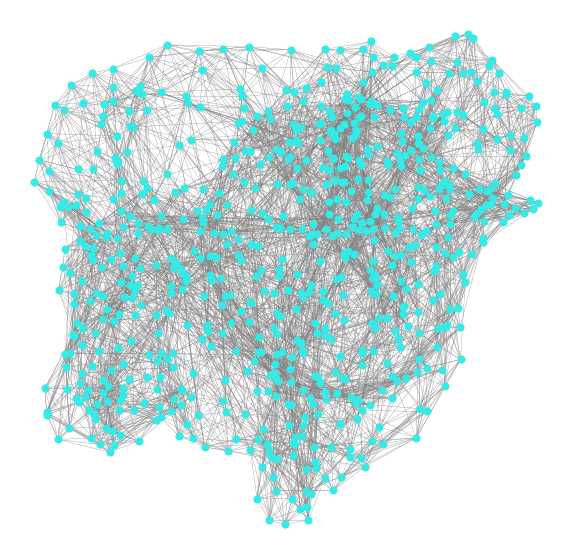

In [118]:
mp1 = mp.copy()
mp1.fit(n_epochs = 1, learning_rate = learning_rate, cluster_channels=1, var_thr=0, verbose=0)    
fig, ax = plt.subplots(figsize = (10, 10))
A = mp1.embedded.graph_.toarray()
G = nx.from_numpy_matrix(np.matrix(A))
layout = nx.spring_layout(G, iterations = 20)
nx.draw(G, layout, ax = ax, node_size = 50, edge_color = 'gray', width = 0.3, node_color= '#34ebe8')

fig.savefig('./svg/graph_randomized.svg', bbox_inches='tight', dpi=300) 

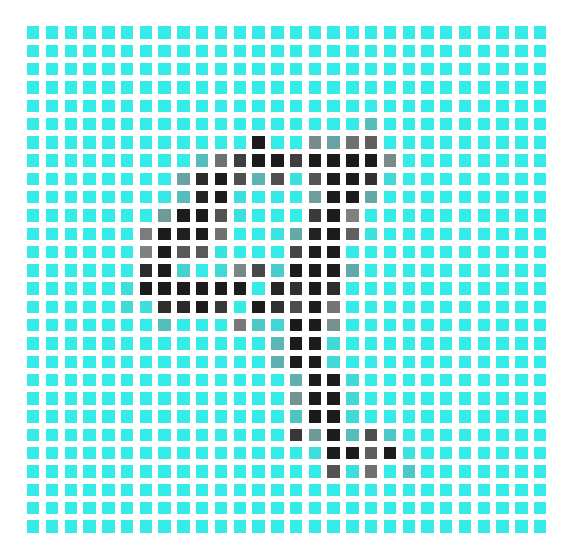

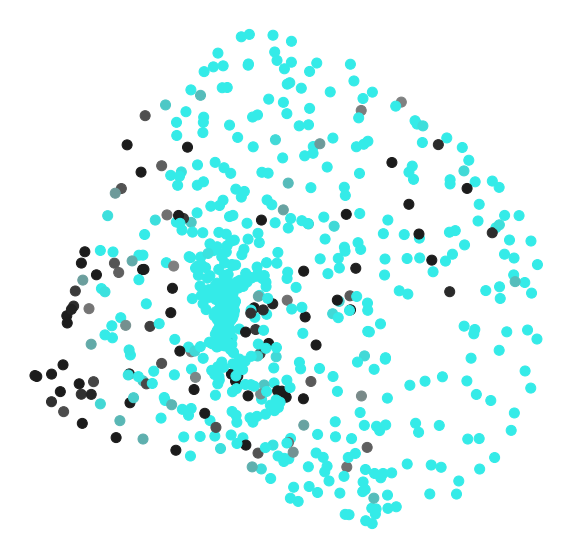

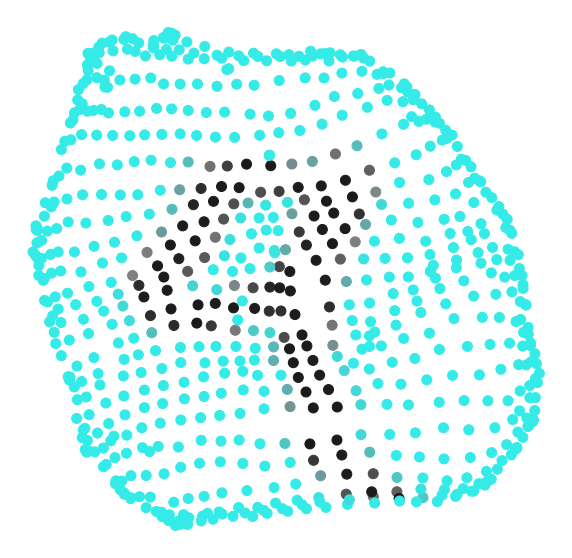

In [529]:
fig, ax = plt.subplots(figsize = (10, 10))
dfg = mp.df_grid.set_index('v')
df = pd.DataFrame(index=mp.flist)
x = df.join(dfg.x).x
y = df.join(dfg.y).y
c = df.join(x_train_df_shuffled.iloc[4].to_frame(name = 'c')).c
xyc = x.to_frame().join(y).join(c)
dfa = pd.DataFrame([range(15, 27), [26 for i in range(12)], [0 for i in range(12)]]).T
dfb = pd.DataFrame([range(0, 28), [27 for i in range(28)], [0 for i in range(28)]]).T
dfc = pd.DataFrame([[27 for i in range(28)], range(0, 28),  [0 for i in range(28)]]).T
dfa.columns = ['x', 'y', 'c']
dfb.columns = ['x', 'y', 'c']
dfc.columns = ['x', 'y', 'c']

xyc = xyc.append(dfa).append(dfb).append(dfc)

ax.scatter(xyc.x, -xyc.y, c = xyc.c, cmap = cmap, s=130, marker='s')
ax.set_xticks([])
ax.set_yticks([])

plt.axis('off')

fig.savefig('./svg/2D_s_gray.svg', bbox_inches='tight', dpi=300) 



from sklearn.manifold import SpectralEmbedding
model = SpectralEmbedding(n_components = 2, n_neighbors = 100, affinity = 'precomputed') #]
dfd = pd.DataFrame(squareform(mp.info_distance), index=mp.alist, columns=mp.alist)
dist = dfd.loc[mp.flist][mp.flist].values

#dist = squareform(mp.info_distance)
affinity_matrix  = np.exp(-(dist ** 2))

se = model.fit_transform(affinity_matrix) #
se /= se.max()
dfi = pd.DataFrame(se, index=mp.flist)
dfi.columns = ['x', 'y']
dfi = dfi.join(x_train_df_shuffled.iloc[4].to_frame(name = 'c'))
plt.figure(figsize=(10,10))
plt.scatter(dfi.x, dfi.y, c = dfi.c, cmap = cmap, s = 100) # c = y_train.astype(int),
plt.axis('off')
fig.savefig('./svg/init_embed.svg', bbox_inches='tight', dpi=300) 



fig, ax = plt.subplots(figsize = (10, 10))

dfs = mp.df_embedding[['x','y']]
dfs = dfs.join(x_train_df_shuffled.iloc[4].to_frame(name = 'c'))

ax.scatter(dfs.x, -dfs.y, c = dfs.c, s=100, cmap = cmap)
plt.axis('off')

fig.savefig('./svg/2D_scatter_gray.svg', bbox_inches='tight', dpi=300) 

In [464]:
mp5 = mp.copy()
mp5.fit(verbose = 0, cluster_channels=5, var_thr = 0, learning_rate=learning_rate, n_epochs=n_epochs)

X_restore_5 = mp5.batch_transform(x_train_df_shuffled.values[idx_to_plot.tolist()], scale=False)

100%|##########| 5/5 [00:00<00:00, 16.44it/s]


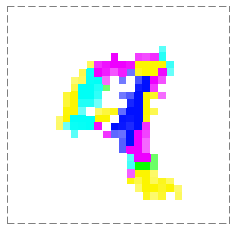

In [465]:
from aggmap import show
x = np.pad(X_restore_5[-1], ((0,1),(1,0), (0, 0)))
show.imshow_wrap(x, color_list = mp5.colormaps.values(), mode = 'linght')

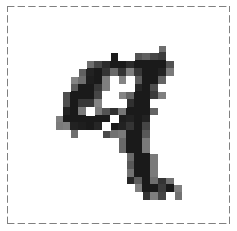

In [466]:
from aggmap import show
x = np.pad(X_restore_5[-1], ((0,1),(1,0), (0, 0)))
show.imshow_wrap(x.sum(axis=-1).reshape(28,28,1), mode= 'lingt', color_list = ['k'])

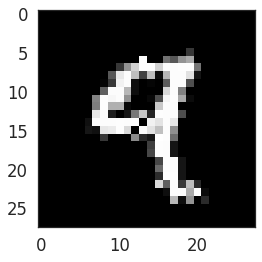

In [453]:
plt.imshow(x.sum(axis=-1), cmap = 'gray')


In [530]:
df_itol = mp5.to_nwk_tree()

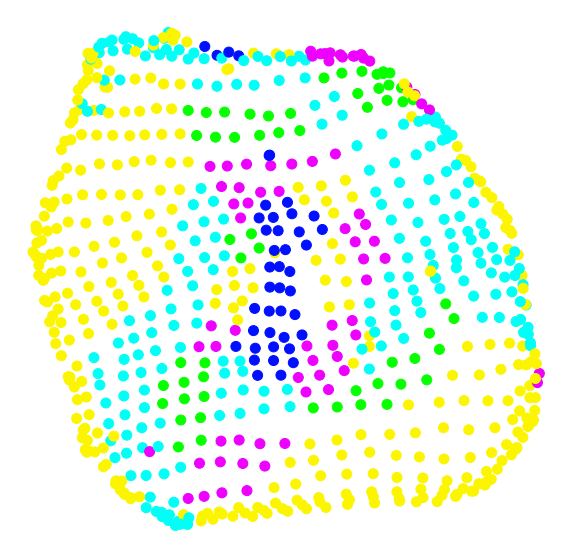

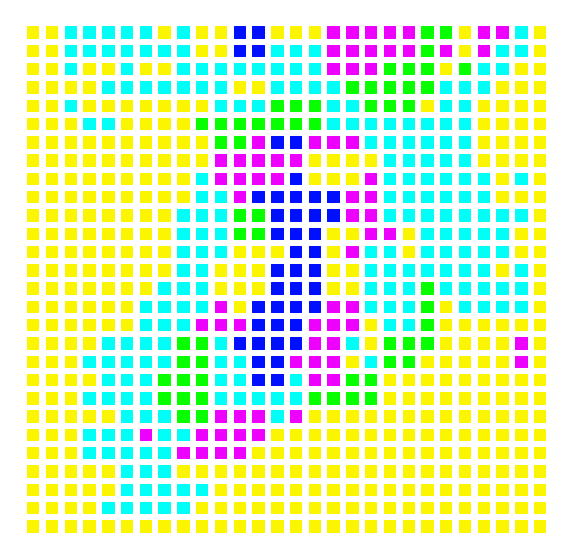

In [531]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(mp5.df_scatter.x, -mp5.df_scatter.y, c = mp5.df_scatter.colors, s=100)
plt.axis('off')
fig.savefig('./svg/2D_scatter.svg', bbox_inches='tight', dpi=300) 


fig, ax = plt.subplots(figsize = (10, 10))
dfg = mp5.df_grid.set_index('v')
df = pd.DataFrame(index=mp.flist)
x = df.join(dfg.x).x
y = df.join(dfg.y).y
c = df.join(dfg.colors).colors
xyc = x.to_frame().join(y).join(c)
dfa = pd.DataFrame([range(15, 27), [26 for i in range(12)], ['#fcf500' for i in range(12)]]).T
dfb = pd.DataFrame([range(0, 28), [27 for i in range(28)], ['#fcf500' for i in range(28)]]).T
dfc = pd.DataFrame([[27 for i in range(28)], range(0, 28),  ['#fcf500' for i in range(28)]]).T
dfa.columns = ['x', 'y', 'colors']
dfb.columns = ['x', 'y', 'colors']
dfc.columns = ['x', 'y', 'colors']

xyc = xyc.append(dfa).append(dfb).append(dfc)

ax.scatter(xyc.x, -xyc.y, c = xyc.colors,  s=130, marker='s')

plt.axis('off')

fig.savefig('./svg/2D_grid.svg', bbox_inches='tight', dpi=300) 